
# End-to-End Indicator ML Strategy (BTCUSDT)

Blueprint notebook to transform the provided feature-rich CSVs into a clean feature layer, label future returns, train a baseline ML model, and backtest simple probability-to-position mappings. The main focus is the 1H dataset, with comparison against 4H and 1D.



## 1. Imports & Paths
Load core dependencies and configure the file locations for each timeframe. The 1H file is treated as the primary source while keeping 4H and 1D available for quick comparisons.


In [1]:

import os
import math
import subprocess
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pd.set_option("display.max_columns", None)


def discover_candidate_data_dirs() -> List[Path]:
    """Enumerate plausible data directories, including env overrides and repo root."""
    candidates: List[Path] = []
    seen = set()

    def add(path_like):
        path = Path(path_like).resolve()
        if path in seen:
            return
        seen.add(path)
        candidates.append(path)

    env_dir = os.getenv("DATA_DIR")
    if env_dir:
        add(env_dir)

    cwd = Path.cwd().resolve()
    add(cwd / "data")
    add(cwd / "notebooks" / "data")
    for parent in cwd.parents:
        add(parent / "data")
        add(parent / "notebooks" / "data")

    try:
        repo_root = Path(
            subprocess.check_output(["git", "rev-parse", "--show-toplevel"], text=True).strip()
        )
        add(repo_root / "data")
        add(repo_root / "notebooks" / "data")
    except Exception:
        pass

    return [p for p in candidates if p.exists()]


def resolve_data_path(filename: str) -> Path:
    data_dirs = discover_candidate_data_dirs()
    attempts = []
    for base in data_dirs:
        candidate = base / filename
        attempts.append(candidate)
        if candidate.exists():
            return candidate
    raise FileNotFoundError(
        f"Data file not found: {filename}. Tried: {attempts}"
    )


def compute_adx(high: pd.Series, low: pd.Series, close: pd.Series, period: int = 14) -> pd.Series:
    """Minimal ADX implementation to avoid dependency on TA-Lib."""
    high = high.fillna(method="ffill")
    low = low.fillna(method="ffill")
    close = close.fillna(method="ffill")
    up_move = high.diff()
    down_move = -low.diff()
    plus_dm = up_move.where((up_move > down_move) & (up_move > 0), 0.0)
    minus_dm = down_move.where((down_move > up_move) & (down_move > 0), 0.0)
    tr1 = high - low
    tr2 = (high - close.shift()).abs()
    tr3 = (low - close.shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    tr_smooth = tr.ewm(alpha=1/period, adjust=False).mean()
    plus_smooth = plus_dm.ewm(alpha=1/period, adjust=False).mean()
    minus_smooth = minus_dm.ewm(alpha=1/period, adjust=False).mean()

    plus_di = 100 * (plus_smooth / tr_smooth).replace([np.inf, -np.inf], np.nan)
    minus_di = 100 * (minus_smooth / tr_smooth).replace([np.inf, -np.inf], np.nan)
    dx = (100 * (plus_di - minus_di).abs() / (plus_di + minus_di)).replace([np.inf, -np.inf], np.nan)
    adx = dx.ewm(alpha=1/period, adjust=False).mean()
    return adx


def add_strategy_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['ret_1'] = df['close'].pct_change()
    df['bb_percent'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
    df['bb_percent'] = df['bb_percent'].clip(-5, 5)
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_basis']

    df['donchian_high_20'] = df['high'].rolling(20).max()
    df['donchian_low_20'] = df['low'].rolling(20).min()
    df['vol_rel_50'] = df['volume'] / df['volume'].rolling(50).mean()

    df['ret_20'] = df['close'].pct_change(20)
    df['ret_50'] = df['close'].pct_change(50)
    df['vol_20'] = df['ret_1'].rolling(20).std()

    df['adx'] = compute_adx(df['high'], df['low'], df['close'])

    if 'atr' in df.columns:
        df['atr_pct'] = df['atr'] / df['close']
    if {'ema_fast', 'ema_slow', 'close'}.issubset(df.columns):
        df['ema_gap_pct'] = (df['ema_fast'] - df['ema_slow']) / df['close']
    if 'rsi' in df.columns:
        df['rsi_smooth'] = df['rsi'].rolling(5).mean()
    if 'macd_hist' in df.columns:
        df['macd_hist_slope'] = df['macd_hist'].diff()

    df = df.replace([np.inf, -np.inf], np.nan).ffill().bfill()
    return df


In [2]:
# Duplicate helpers consolidated in the previous cell to keep a single source of truth for ADX and feature engineering.

In [3]:

RENAME_MAP = {
    'time': 'time',
    'open': 'open',
    'high': 'high',
    'low': 'low',
    'close': 'close',
    'Volume': 'volume',
    'VWAP': 'vwap',
    'Upper Band #1': 'bb1_upper',
    'Lower Band #1': 'bb1_lower',
    'Basis': 'bb_basis',
    'Upper': 'bb_upper',
    'Lower': 'bb_lower',
    'Up Trend': 'trend_up',
    'Down Trend': 'trend_down',
    'EMA': 'ema_fast',
    'EMA.1': 'ema_slow',
    'Conversion Line': 'ichi_conv',
    'Base Line': 'ichi_base',
    'Lagging Span': 'ichi_lag',
    'Leading Span A': 'ichi_span_a',
    'Leading Span B': 'ichi_span_b',
    'Upper.1': 'channel_upper',
    'Average': 'channel_mid',
    'Lower.1': 'channel_lower',
    'RSI': 'rsi',
    'RSI-based MA': 'rsi_ma',
    'Regular Bullish': 'div_bull',
    'Regular Bullish Label': 'div_bull_label',
    'Regular Bearish': 'div_bear',
    'Regular Bearish Label': 'div_bear_label',
    'Histogram': 'macd_hist',
    'MACD': 'macd',
    'Signal': 'macd_signal',
    'ATR': 'atr',
    'K': 'stoch_k',
    'D': 'stoch_d',
    '%R': 'williams_r',
}

DROP_PATTERNS = [
    'PlotCandle',
]
DROP_EXACT = {'Plot', 'Plot.1', 'Plot.2', 'div_bull_label', 'div_bear_label'}



## 3. Data Loading & Feature Layer Construction
Helper functions to load a timeframe, clean columns, fill gaps, and add a few helper features (returns, Bollinger %B, Bollinger width). The result is the **feature layer** ready for labeling and modeling.


In [4]:
def rename_and_filter_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.rename(columns=RENAME_MAP)
    keep_cols = []
    for col in df.columns:
        if any(pattern in col for pattern in DROP_PATTERNS):
            continue
        if col in DROP_EXACT:
            continue
        keep_cols.append(col)
    return df[keep_cols]



## 4. Labeling (Binary Up/Down)
Create a forward return label for a chosen horizon. By default we use 4 bars ahead. `y = 1` when the future return is positive, else `0`.


In [5]:

def add_labels(df: pd.DataFrame, horizon: int = 4) -> pd.DataFrame:
    future_price = df['close'].shift(-horizon)
    df['future_return'] = future_price / df['close'] - 1
    df['y'] = (df['future_return'] > 0).astype(int)
    df = df.dropna(subset=['future_return'])
    return df



## 5. Train/Validation/Test Split (Time-Based)
Use chronological splits (70/15/15). No shuffling is applied to respect temporal order.


In [6]:

@dataclass
class DatasetSplit:
    X_train: pd.DataFrame
    X_val: pd.DataFrame
    X_test: pd.DataFrame
    y_train: pd.Series
    y_val: pd.Series
    y_test: pd.Series
    future_val: pd.Series
    future_test: pd.Series
    train_df: pd.DataFrame
    val_df: pd.DataFrame
    test_df: pd.DataFrame


def time_based_split(df: pd.DataFrame, feature_cols: List[str]) -> DatasetSplit:
    n = len(df)
    train_end = int(n * 0.7)
    val_end = int(n * 0.85)

    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]

    X_train, y_train = train[feature_cols], train['y']
    X_val, y_val = val[feature_cols], val['y']
    X_test, y_test = test[feature_cols], test['y']

    return DatasetSplit(
        X_train=X_train,
        X_val=X_val,
        X_test=X_test,
        y_train=y_train,
        y_val=y_val,
        y_test=y_test,
        future_val=val['future_return'],
        future_test=test['future_return'],
        train_df=train,
        val_df=val,
        test_df=test,
    )



## 6. Modeling + Threshold Search
Train a LightGBM classifier inside a scikit-learn pipeline (imputer + scaler). Validation Sharpe on the forward-return horizon is used to pick the best probability threshold for entries.


In [7]:
def compute_sharpe(returns: np.ndarray, periods_per_year: int = 365) -> float:
    ret = np.array(returns)
    if ret.std() == 0:
        return 0.0
    return (ret.mean() * periods_per_year) / (ret.std() * math.sqrt(periods_per_year))


def evaluate_threshold(probs: np.ndarray, future_returns: pd.Series, candidate_thr: List[float]):
    best_sharpe, best_thr = -np.inf, None
    for thr in candidate_thr:
        positions = (probs > thr).astype(int)
        strat_ret = positions * future_returns.values
        sharpe = compute_sharpe(strat_ret)
        if sharpe > best_sharpe:
            best_sharpe, best_thr = sharpe, thr
    return best_thr, best_sharpe


def train_model(split: DatasetSplit, feature_cols: List[str]):
    imputer = SimpleImputer(strategy="median")
    scaler = StandardScaler()

    imputer.fit(split.X_train)
    scaler.fit(imputer.transform(split.X_train))

    def transform(df: pd.DataFrame) -> pd.DataFrame:
        arr = imputer.transform(df)
        arr = scaler.transform(arr)
        return pd.DataFrame(arr, columns=feature_cols, index=df.index)

    X_train = transform(split.X_train)
    X_val = transform(split.X_val)
    X_test = transform(split.X_test)

    model = lgb.LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary",
    )
    model.fit(X_train, split.y_train)

    val_probs = model.predict_proba(X_val)[:, 1]
    candidate_thr = [0.5, 0.55, 0.6, 0.65, 0.7]
    best_thr, best_sharpe = evaluate_threshold(val_probs, split.future_val, candidate_thr)

    test_probs = model.predict_proba(X_test)[:, 1]
    positions_test = (test_probs > best_thr).astype(int)
    strat_ret_test = positions_test * split.future_test.values

    metrics = {
        "val_accuracy": accuracy_score(split.y_val, (val_probs > 0.5).astype(int)),
        "test_accuracy": accuracy_score(split.y_test, (test_probs > 0.5).astype(int)),
        "val_sharpe@best_thr": best_sharpe,
        "test_sharpe@best_thr": compute_sharpe(strat_ret_test),
        "threshold": best_thr,
    }

    reports = {
        "val_report": classification_report(split.y_val, (val_probs > 0.5).astype(int), digits=3),
        "test_report": classification_report(split.y_test, (test_probs > 0.5).astype(int), digits=3),
    }

    processed = {"train": X_train, "val": X_val, "test": X_test}

    return model, metrics, reports, val_probs, test_probs, processed



## 7. End-to-End Runner (Per Timeframe)
Combine all steps for a given timeframe and collect summary metrics. The primary focus is `1h`, with side-by-side stats for `4h` and `1d`.


In [ ]:
# Data locations and feature builder
PROJECT_ROOT = Path.cwd()
DATA_PATHS = {
    '1h': resolve_data_path("BINANCE_BTCUSDT.P, 60.csv"),
    '4h': resolve_data_path("BINANCE_BTCUSDT.P, 240.csv"),
    '1d': resolve_data_path("BINANCE_BTCUSDT.P, 1D.csv"),
}


def load_raw_timeframe(path: Path) -> pd.DataFrame:
    """Load a timeframe CSV, harmonize columns, and sort by time."""
    df = pd.read_csv(path)
    df = rename_and_filter_columns(df)
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time').reset_index(drop=True)
    df = df.replace([np.inf, -np.inf], np.nan).ffill().bfill()
    return df


def build_feature_layer(path: Path) -> pd.DataFrame:
    """Create the model-ready dataframe with engineered features."""
    df = load_raw_timeframe(path)
    df = add_strategy_features(df)
    df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)
    return df


In [8]:

def run_timeframe(key: str, horizon: int = 4):
    df = build_feature_layer(DATA_PATHS[key])
    df = add_labels(df, horizon=horizon)

    feature_cols = [
        col for col in df.columns
        if col not in {'time', 'y', 'future_return'}
        and not col.startswith('div_')  # drop visual divergence labels
    ]

    split = time_based_split(df, feature_cols)
    model, metrics, reports, val_probs, test_probs, processed = train_model(split, feature_cols)

    val_probs = pd.Series(val_probs, index=split.X_val.index, name='prob_up')
    test_probs = pd.Series(test_probs, index=split.X_test.index, name='prob_up')

    summary = {
        'timeframe': key,
        'rows': len(df),
        **metrics,
    }
    return {
        'summary': summary,
        'reports': reports,
        'model': model,
        'feature_cols': feature_cols,
        'split': split,
        'processed_features': processed,
        'val_probs': val_probs,
        'test_probs': test_probs,
        'df': df,
    }

results = {tf: run_timeframe(tf) for tf in DATA_PATHS}
summary_df = pd.DataFrame([results[tf]['summary'] for tf in DATA_PATHS])
summary_df


[LightGBM] [Info] Number of positive: 9162, number of negative: 8666
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10710
[LightGBM] [Info] Number of data points in the train set: 17828, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513911 -> initscore=0.055657
[LightGBM] [Info] Start training from score 0.055657
[LightGBM] [Info] Number of positive: 4863, number of negative: 4675
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10708
[LightGBM] [Info] Number of data points in the train set: 9538, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509855 -> initscore=0.039426
[LightGBM] [Info] Start training from score 0.039426
[LightGBM] [Info] N

,timeframe,rows,val_accuracy,test_accuracy,val_sharpe@best_thr,test_sharpe@best_thr,threshold
0,1h,25469,0.542147,0.527349,1.037007,0.490884,0.5
1,4h,13627,0.517123,0.519804,1.629787,0.011503,0.5
2,1d,2269,0.482353,0.495601,2.934018,0.347863,0.5



### Classification Reports (quick check)
View precision/recall/F1 for each timeframe to understand base discrimination performance.


In [9]:

for tf, res in results.items():
    print(f"=== {tf} ===")
    print(res['reports']['test_report'])


=== 1h ===
              precision    recall  f1-score   support

           0      0.546     0.341     0.420      1916
           1      0.519     0.714     0.601      1905

    accuracy                          0.527      3821
   macro avg      0.532     0.528     0.511      3821
weighted avg      0.532     0.527     0.510      3821

=== 4h ===
              precision    recall  f1-score   support

           0      0.507     0.754     0.606      1003
           1      0.554     0.295     0.385      1042

    accuracy                          0.520      2045
   macro avg      0.531     0.524     0.495      2045
weighted avg      0.531     0.520     0.493      2045

=== 1d ===
              precision    recall  f1-score   support

           0      0.484     0.951     0.642       162
           1      0.652     0.084     0.149       179

    accuracy                          0.496       341
   macro avg      0.568     0.517     0.395       341
weighted avg      0.572     0.496     0.3


## 8. SHAP Explainability (Feature Importance)
Use SHAP to see which indicators drive the `prob_up` predictions. Run on a subset for speed.


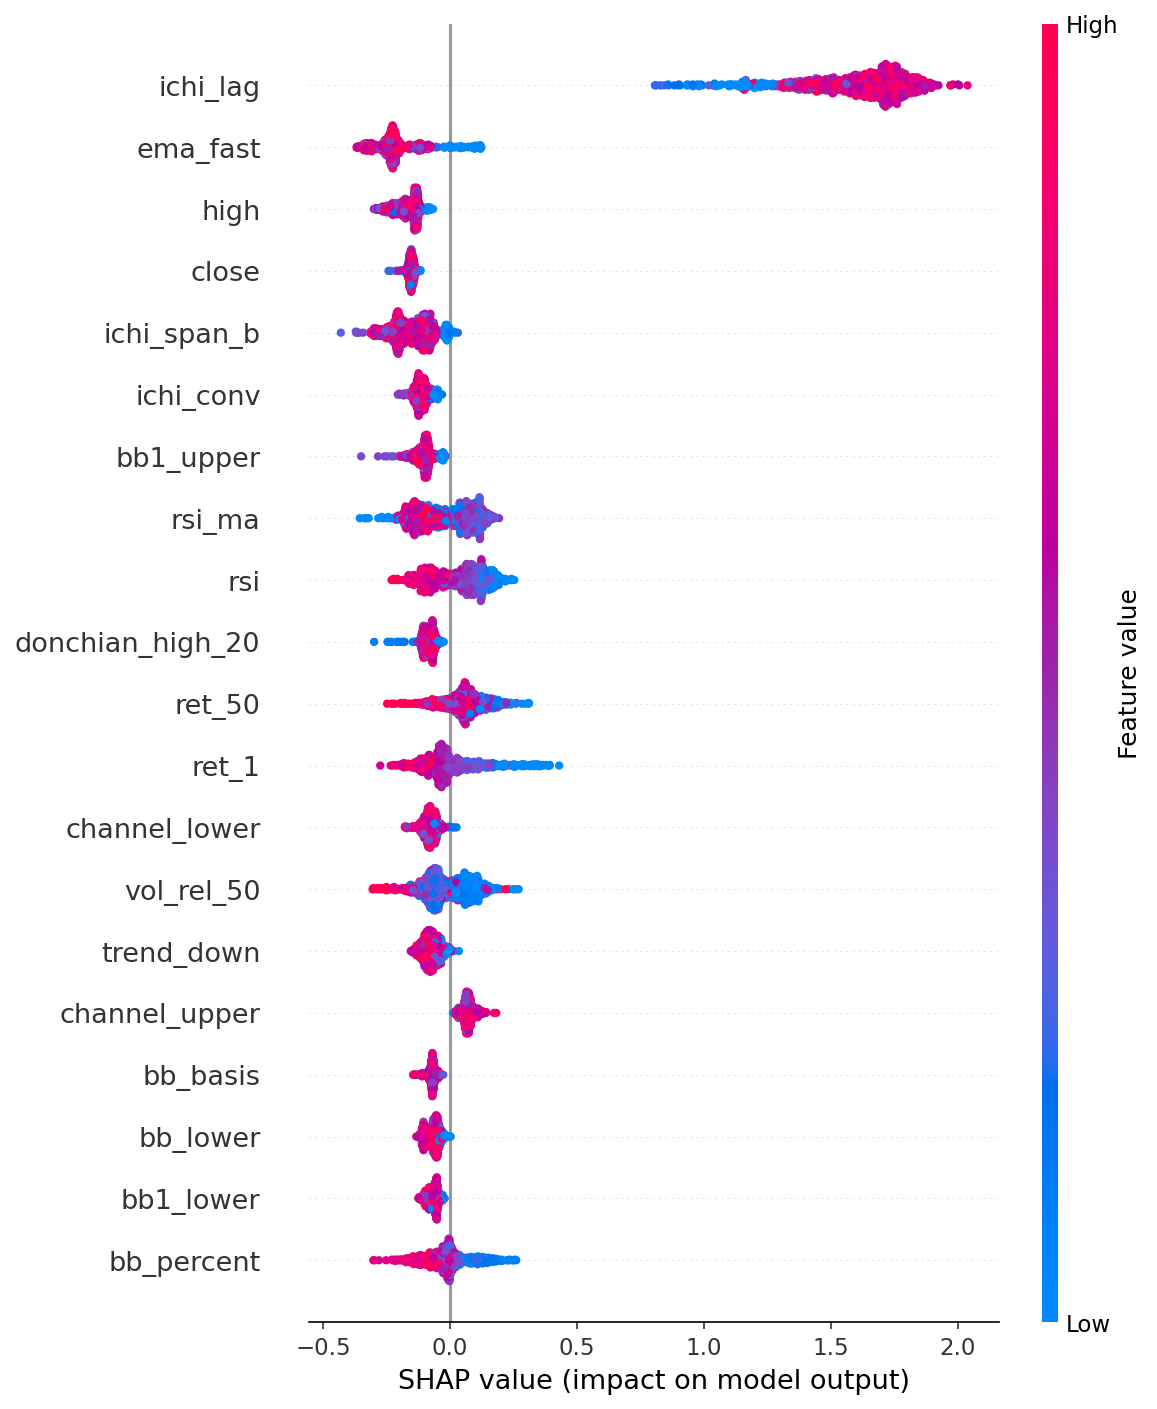

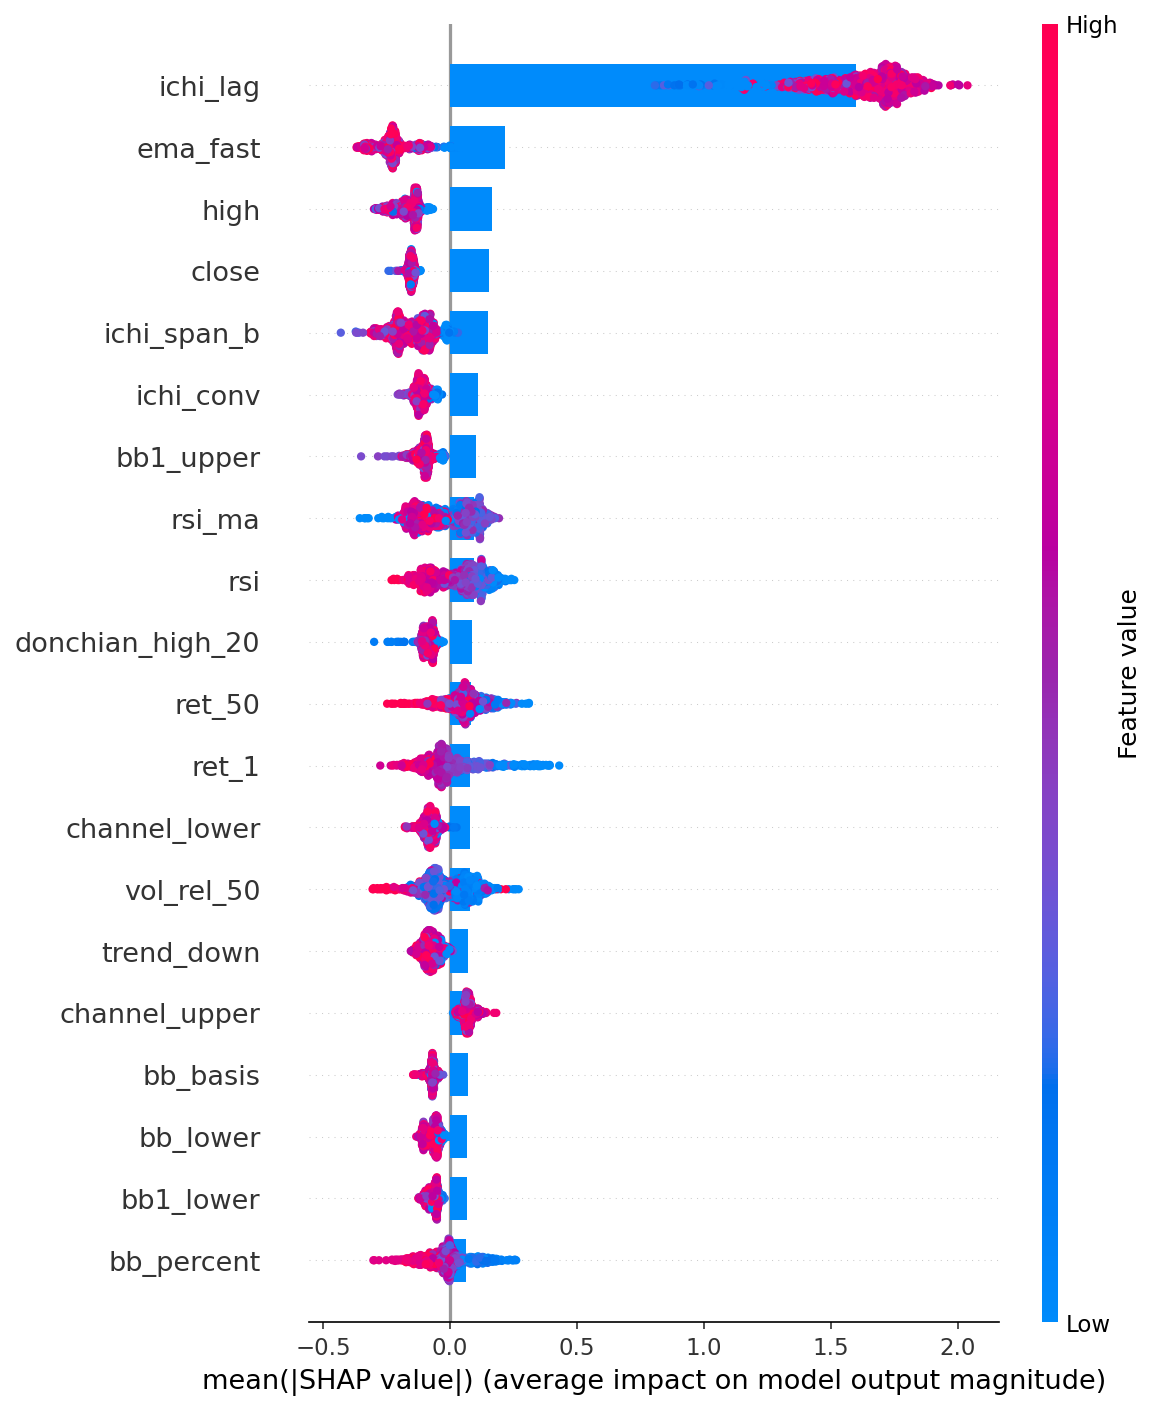

In [10]:
# Uncomment if shap is not available in your environment
# %pip install shap

import io
from pathlib import Path
import matplotlib
matplotlib.use('Agg')
import warnings
from IPython.display import Image, display

# Suppress noisy LightGBM / SHAP output format warnings
warnings.filterwarnings(
    'ignore',
    message='LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray',
    category=UserWarning,
)

IMG_DIR = Path('outputs/shap')
IMG_DIR.mkdir(parents=True, exist_ok=True)

try:
    import shap
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    print("shap is not installed in this environment. Install with `pip install shap` to view explainability plots.")
else:
    shap.initjs()

    primary = results['1h']
    X_explain = primary['processed_features']['test'].sample(
        n=min(1000, len(primary['processed_features']['test'])), random_state=42
    )
    explainer = shap.TreeExplainer(primary['model'])
    shap_values = explainer.shap_values(X_explain)
    if isinstance(shap_values, list):
        shap_values_class1 = shap_values[1] if len(shap_values) > 1 else shap_values[0]
    else:
        shap_values_class1 = shap_values

    def _save_and_display(fig, filename: str):
        out_path = IMG_DIR / filename
        buf = io.BytesIO()
        fig.savefig(out_path, bbox_inches='tight', dpi=150)
        fig.savefig(buf, format='png', bbox_inches='tight', dpi=150)
        buf.seek(0)
        display(Image(data=buf.read(), format='png', embed=True))

    try:
        shap.summary_plot(shap_values_class1, X_explain, feature_names=primary['feature_cols'], show=False)
        _save_and_display(plt.gcf(), 'shap_beeswarm_1h.png')

        shap.summary_plot(
            shap_values_class1,
            X_explain,
            feature_names=primary['feature_cols'],
            plot_type='bar',
            show=False,
        )
        _save_and_display(plt.gcf(), 'shap_bar_1h.png')
    except Exception as exc:
        print(f"SHAP plotting skipped: {exc}")
    finally:
        plt.close('all')



## 9. Next Steps & Risk Layer
- Apply strategy-specific filters (reversal/trend/volatility) using the `prob_up` outputs and indicators (RSI, bb_percent, macd_hist, EMA stacks, ATR).
- Add risk management: ATR-based SL/TP, max risk per trade, exposure caps.
- Extend to multi-asset or orderbook factors when data is available.


## 10. Strategy pack implementation (13 strategies)
Below are executable, backtest-ready implementations for the strategy templates you shared (now 13 total). They consume the `prob_up` outputs produced above plus the indicator features already in the dataset. Strategies that require unavailable data (funding/orderbook/multi-asset) will still emit a status row so you see coverage gaps.


### Strategy checklist (entries + exits)
Below are the detailed rules you shared so they live next to the executable pack. Each block follows the same flow: **indikator/features → ML prob_up → strategy rule → backtest metric**. Exits are noted where specified.

1) **Reversal – Sideways (ADX < 20)**
   - Features: rsi, macd_hist, vwap, volume, bb_percent, bb_width (+ optional adx).
   - Model: XGBoostClassifier (baseline: LightGBM/RandomForest). Target: future_return 1–3 bar > 0.
   - Entry: `sideways = adx < 20`; long if `prob_up > 0.60` (+ filter rsi < 30 & bb_percent < 0.1); optional short if `prob_up < 0.40` (+ filter rsi > 70 & bb_percent > 0.9).

2) **Trend-Following – Bull/Bear (ADX > 25)**
   - Features: ema_20/50/200, adx, relative volume. Model: RF/LightGBM.
   - Entry: `bull_trend` = adx > 25 & ema_20 > ema_50 > ema_200; go long if `prob_up > 0.55`. `bear_trend` = adx > 25 & ema_20 < ema_50 < ema_200; short if `prob_up < 0.45`. Flat if adx < 20.

3) **Volatility Mean-Reversion (crypto heavy vol)**
   - Features: bb_percent, bb_width, atr, rsi. Model: LightGBM; target = rebound in 2–4 bars.
   - Entry: `extreme_oversold = (bb_percent < 0.05) & (rsi < 25)`; `high_vol = bb_width > rolling_median(bb_width, 100)`; long if both and `prob_up > 0.65`.
   - Exit idea: rsi > 50 or bb_percent > 0.5, or max hold 5–10 bars.

4) **Orderbook Momentum (advanced, needs L2 data)**
   - Features: bid-ask volume ratio, imbalance, volume spike. Model: LSTM or XGBoost (short window).
   - Entry: `strong_imbalance = imbalance > 0.6`; long if `prob_up > 0.7`; short if `prob_up < 0.3`. Use low-latency backtest with slippage assumptions.

5) **Multi-Timeframe Ensemble (1H+4H+1D)**
   - Features: 1H (RSI/EMA/volume), 4H (MACD), 1D (EMA200/ADX/trend). Model: LightGBM per TF → voting/stacking.
   - Entry: align to 1H; position = 1 if `prob_1h > 0.55` & `prob_4h > 0.60` & `prob_1d > 0.50`; else 0. Stacking: fit logistic meta on stacked probs, use `meta_prob_up` as filter.

6) **Breakout & Volatility Expansion**
   - Features: donchian_high/low distance, bb_width or ATR, volume spike. Model: LGBM/XGBoost; label = breakout follow-through.
   - Entry: `breaking_up = close > donchian_high & bb_width > thr_vol`; `volume_spike = volume > 1.5 * rolling_mean(volume, 50)`; long if both and `prob_up > 0.6`.

7) **Time-Series Momentum + Vol Targeting**
   - Features: mom_20/mom_50, std_20, atr, distance to EMA, adx. Model: LogisticReg/XGBoost for “healthy momentum.”
   - Entry: `high_mom = mom > mom.quantile(0.7)`; long if high_mom and `prob_up > 0.55`.
   - Overlay: `leverage = clip(target_vol / realized_vol, 0, 3)`; `position_scaled = position * leverage`.

8) **Funding/Basis Carry (perp BTC/ETH)**
   - Features: funding rate + rolling avg, basis (perp-spot)/spot, volume, OI, vol. Model: LogisticReg/XGBoost.
   - Entry: `high_pos_funding = funding > funding.quantile(0.8)`; `strong_trend_down = ema_fast < ema_slow`; short perp if high_pos_funding & not strong_trend_down & `prob_up < 0.45`. Simple mode: avoid long when funding expensive.

9) **Cross-Sectional Momentum / Factor Rotation (multi-coin)**
   - Features per symbol: momentum (ret_20), liquidity/volume, trend strength (ADX/EMA alignment). Model optional: LightGBM for expected return.
   - Entry: rank by mom_20 each period; long top N; with ML, long top prob_up names.

10) **Hybrid EMA Crossover + Logistic Regression Filter**
   - Features: ema_fast/slow/200, adx, rsi, macd_hist, atr, relative volume. Model: LogisticRegression (L1/L2).
   - Entry: `bull_cross = ema_fast > ema_slow > ema_200`; `trend_ok = adx > 20`; base_long = both true; take long if base_long & `prob_up > 0.55`.

11) **Linear Regression Expected-Return Factor Model**
   - Features: ret_5/ret_20, distance to ema_50/ema_200, atr, bb_width, rsi, stoch_k/d, williams_r, relative volume. Model: Ridge/Lasso regression on future return.
   - Entry: `score = pred_return / rolling_std(pred_return, 100)`; long if score > 0.3; short if score < -0.3.

12) **VWAP Reversion / VWAP Trend ML (intraday)**
   - Features: (close - vwap)/vwap, rsi, bb_percent, bb_width, volume spike, time-of-day, atr. Model: LogisticRegression/MLP; label = revert-to-VWAP vs trend-away.
   - Entry example (reversion): `far_below_vwap = close < vwap * (1 - 0.003)`; long if far_below_vwap & `prob_revert > 0.6`. Trend-follow version: if far_above_vwap & prob_revert low, follow trend.

13) **TP-vs-SL Hit Probability Filter**
   - Features: ATR, distances to support/resistance, rsi, macd_hist, EMA/ADX trend, vol/volume. Model: LogisticReg/XGBoost/LightGBM trained on synthetic TP/SL path outcomes.
   - Entry: `prob_win = P(TP before SL)`; only take base signals where `prob_win > 0.6`; `position = sign(base_signal)` gated by prob_win.


In [11]:

from typing import Callable
import numpy as np


def fetch_series(df: pd.DataFrame, *names: str, default: float = 0.0) -> pd.Series:
    for name in names:
        if name in df.columns:
            return df[name]
    return pd.Series(default, index=df.index, dtype=float)


def compute_max_drawdown(ret: pd.Series) -> float:
    equity = (1 + ret.fillna(0)).cumprod()
    peak = equity.cummax()
    dd = equity / peak - 1
    return float(dd.min()) if len(dd) else 0.0


def strategy_metrics(positions: pd.Series, future_returns: pd.Series, name: str, note: str = "") -> Dict[str, float]:
    strat_ret = positions.fillna(0) * future_returns.fillna(0)
    trades = int((positions != 0).sum())
    metrics = {
        'strategy': name,
        'trades': trades,
        'exposure': float((positions != 0).mean()),
        'total_return': float(strat_ret.sum()),
        'avg_bar_return': float(strat_ret.mean()),
        'avg_trade_return': float(strat_ret[positions != 0].mean()) if trades else 0.0,
        'sharpe': compute_sharpe(strat_ret),
        'max_drawdown': compute_max_drawdown(strat_ret),
        'win_rate': float((strat_ret > 0).mean()) if len(strat_ret) else 0.0,
        'note': note or 'ok',
    }
    return metrics


def run_strategy_pack(result: Dict) -> pd.DataFrame:
    df = result['split'].test_df.copy().reset_index(drop=True)
    df['prob_up'] = result['test_probs'].reset_index(drop=True)

    def volatility_guard(df, max_atr_pct: float = 0.05) -> pd.Series:
        atr_pct = fetch_series(df, 'atr_pct', default=np.nan)
        guard = atr_pct < max_atr_pct
        return guard.fillna(True)

    def reversal(df):
        positions = pd.Series(0, index=df.index, dtype=float)
        adx = fetch_series(df, 'adx')
        bb_width_median = df['bb_width'].rolling(50).median()
        sideways = (adx < 18) | (df['bb_width'] <= bb_width_median)
        vol_guard = volatility_guard(df, max_atr_pct=0.06)
        macd_slope = fetch_series(df, 'macd_hist_slope')

        bullish = (df['rsi'] < 28) & (df['bb_percent'] < 0.1) & (macd_slope >= macd_slope.median())
        bearish = (df['rsi'] > 72) & (df['bb_percent'] > 0.9) & (macd_slope <= macd_slope.median())

        positions[sideways & vol_guard & bullish & (df['prob_up'] > 0.62)] = 1
        positions[sideways & vol_guard & bearish & (df['prob_up'] < 0.38)] = -1
        return positions

    def trend_follow(df):
        positions = pd.Series(0, index=df.index, dtype=float)
        adx = fetch_series(df, 'adx')
        ema_fast = fetch_series(df, 'ema_20', 'ema_fast')
        ema_slow = fetch_series(df, 'ema_50', 'ema_slow')
        ema_200 = fetch_series(df, 'ema_200')
        macd_hist = fetch_series(df, 'macd_hist')
        vol_guard = volatility_guard(df, max_atr_pct=0.08)

        in_trend = adx > 25
        pullback_ok = df['close'] > ema_fast * 0.995
        bull = in_trend & (ema_fast > ema_slow) & (ema_slow > ema_200)
        bear = in_trend & (ema_fast < ema_slow) & (ema_slow < ema_200)

        positions[bull & vol_guard & pullback_ok & (macd_hist > 0) & (df['prob_up'] > 0.58)] = 1
        positions[bear & vol_guard & ~pullback_ok & (macd_hist < 0) & (df['prob_up'] < 0.42)] = -1
        return positions

    def vol_mean_reversion(df):
        positions = pd.Series(0, index=df.index, dtype=float)
        extreme_oversold = (df['bb_percent'] < 0.05) & (df['rsi'] < 25)
        extreme_overbought = (df['bb_percent'] > 0.95) & (df['rsi'] > 72)
        high_vol = df['bb_width'] > df['bb_width'].rolling(100).median()
        vol_guard = volatility_guard(df, max_atr_pct=0.07)

        positions[extreme_oversold & high_vol & vol_guard & (df['prob_up'] > 0.65)] = 1
        positions[extreme_overbought & high_vol & vol_guard & (df['prob_up'] < 0.35)] = -1
        return positions

    def orderbook_momentum(df):
        positions = pd.Series(0, index=df.index, dtype=float)
        if 'imbalance' in df.columns:
            strong_imbalance = df['imbalance'] > 0.6
            positions[strong_imbalance & (df['prob_up'] > 0.7)] = 1
            positions[df['prob_up'] < 0.3] = -1
            return positions, 'ok'
        if 'vol_rel_50' in df.columns:
            imbalance_proxy = df['vol_rel_50'] > 1.5
            positions[imbalance_proxy & (df['prob_up'] > 0.7)] = 1
            positions[df['prob_up'] < 0.3] = -1
            return positions, 'using volume spike as imbalance proxy'
        return positions, 'requires orderbook/volume spike data'

    def multi_timeframe(df):
        positions = pd.Series(0, index=df.index, dtype=float)
        return positions, 'computed in dedicated ensemble cell'

    def breakout(df):
        positions = pd.Series(0, index=df.index, dtype=float)
        donchian_high = fetch_series(df, 'donchian_high_20', 'donchian_high')
        vol_thresh = df['bb_width'].rolling(50).median()
        volume_spike = fetch_series(df, 'vol_rel_50') > 1.5
        breaking_up = (df['close'] > donchian_high) & (df['bb_width'] > vol_thresh)
        ema_slow = fetch_series(df, 'ema_50', 'ema_slow')
        structure_ok = df['close'] > ema_slow
        vol_guard = volatility_guard(df, max_atr_pct=0.08)

        positions[breaking_up & volume_spike & structure_ok & vol_guard & (df['prob_up'] > 0.62)] = 1
        return positions

    def ts_momentum(df):
        positions = pd.Series(0, index=df.index, dtype=float)
        mom = fetch_series(df, 'mom_20', default=0.0)
        if 'mom_20' not in df.columns and 'close' in df.columns:
            mom = df['close'] / df['close'].shift(20) - 1
        high_mom = mom > mom.quantile(0.7)
        vol_guard = volatility_guard(df, max_atr_pct=0.08)
        positions[high_mom & vol_guard & (df['prob_up'] > 0.55)] = 1
        return positions

    def funding_carry(df):
        positions = pd.Series(0, index=df.index, dtype=float)
        if 'funding' not in df.columns:
            return positions, 'requires funding/basis data'
        high_pos_funding = df['funding'] > df['funding'].quantile(0.8)
        ema_fast = fetch_series(df, 'ema_fast', 'ema_20')
        ema_slow = fetch_series(df, 'ema_slow', 'ema_50')
        strong_trend_down = ema_fast < ema_slow
        positions[high_pos_funding & ~strong_trend_down & (df['prob_up'] < 0.45)] = -1
        return positions, 'ok'

    def cross_sectional(df):
        positions = pd.Series(0, index=df.index, dtype=float)
        return positions, 'requires multi-asset panel data'

    def hybrid_ema_lr(df):
        positions = pd.Series(0, index=df.index, dtype=float)
        ema_fast = fetch_series(df, 'ema_fast', 'ema_20')
        ema_slow = fetch_series(df, 'ema_slow', 'ema_50')
        ema_200 = fetch_series(df, 'ema_200')
        adx = fetch_series(df, 'adx')
        vol_guard = volatility_guard(df, max_atr_pct=0.07)
        bull_cross = (ema_fast > ema_slow) & (ema_slow > ema_200)
        trend_ok = adx > 20
        base_long = bull_cross & trend_ok & vol_guard
        positions[base_long & (df['prob_up'] > 0.55)] = 1
        return positions

    def linear_factor_model(df):
        positions = pd.Series(0, index=df.index, dtype=float)
        if 'pred_return' not in df.columns:
            return positions, 'requires regression predictions'
        score = df['pred_return'] / df['pred_return'].rolling(100).std()
        positions[score > 0.3] = 1
        positions[score < -0.3] = -1
        return positions, 'ok'

    def vwap_reversion(df):
        positions = pd.Series(0, index=df.index, dtype=float)
        if 'vwap' not in df.columns:
            return positions, 'requires vwap'
        far_below = df['close'] < df['vwap'] * (1 - 0.003)
        far_above = df['close'] > df['vwap'] * (1 + 0.003)
        prob_revert = fetch_series(df, 'prob_revert', default=df['prob_up'])
        vol_guard = volatility_guard(df, max_atr_pct=0.06)

        positions[far_below & vol_guard & (prob_revert > 0.6)] = 1
        positions[far_above & vol_guard & (prob_revert < 0.4)] = -1
        return positions, 'using prob_revert/prob_up'

    def tp_vs_sl_filter(df):
        positions = pd.Series(0, index=df.index, dtype=float)
        if 'prob_win' in df.columns and 'base_signal' in df.columns:
            positions[df['prob_win'] > 0.6] = np.sign(df['base_signal'])
            return positions, 'ok'
        return positions, 'requires prob_win + base_signal inputs'

    strategies: List[Tuple[str, Callable[[pd.DataFrame], Tuple[pd.Series, str]]]] = [
        ('1_reversal', lambda d: (reversal(d), 'ok')),
        ('2_trend_follow', lambda d: (trend_follow(d), 'ok')),
        ('3_vol_mean_reversion', lambda d: (vol_mean_reversion(d), 'ok')),
        ('4_orderbook_momentum', orderbook_momentum),
        ('5_multi_timeframe_ensemble', multi_timeframe),
        ('6_breakout_vol_expansion', lambda d: (breakout(d), 'ok')),
        ('7_ts_momentum_vol_target', lambda d: (ts_momentum(d), 'ok')),
        ('8_funding_carry', funding_carry),
        ('9_cross_sectional_momentum', cross_sectional),
        ('10_hybrid_ema_lr_filter', lambda d: (hybrid_ema_lr(d), 'ok')),
        ('11_linear_factor_model', linear_factor_model),
        ('12_vwap_reversion_trend', vwap_reversion),
        ('13_tp_vs_sl_filter', tp_vs_sl_filter),
    ]

    rows = []
    for name, fn in strategies:
        positions, note = fn(df)
        rows.append(strategy_metrics(positions, df['future_return'], name, note))
    return pd.DataFrame(rows)


strategy_tables = {tf: run_strategy_pack(results[tf]) for tf in results}
strategy_tables['1h']

strategy_summary = pd.concat(strategy_tables, names=['timeframe', 'row']).reset_index(level=0)
strategy_summary


,timeframe,strategy,trades,exposure,total_return,avg_bar_return,avg_trade_return,sharpe,max_drawdown,win_rate,note
row,,,,,,,,,,,
0,1h,1_reversal,15,0.003926,-0.013823,-0.000004,-0.000922,-0.177891,-0.028260,0.002094,ok
1,1h,2_trend_follow,572,0.149699,0.178583,0.000047,0.000312,0.249146,-0.222084,0.081392,ok
2,1h,3_vol_mean_reversion,14,0.003664,0.061329,0.000016,0.004381,0.346882,-0.053085,0.002879,ok
3,1h,4_orderbook_momentum,178,0.046585,0.463930,0.000121,0.002606,0.998355,-0.083302,0.028788,using volume spike as imbalance proxy
4,1h,5_multi_timeframe_ensemble,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,computed in dedicated ensemble cell
5,1h,6_breakout_vol_expansion,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ok
6,1h,7_ts_momentum_vol_target,422,0.110442,-0.192852,-0.000050,-0.000457,-0.363185,-0.337063,0.050249,ok
7,1h,8_funding_carry,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,requires funding/basis data
8,1h,9_cross_sectional_momentum,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,requires multi-asset panel data



### Multi-timeframe ensemble (1H + 4H + 1D)
This cell aligns the three test splits with `merge_asof` (using 1H as the base), then applies the ensemble rule: 1H > 0.55, 4H > 0.60, 1D > 0.50. It reports backtest metrics on the aligned sample.


In [12]:

base = results['1h']['split'].test_df[['time', 'future_return']].copy().reset_index(drop=True)
base['prob_1h'] = results['1h']['test_probs'].reset_index(drop=True)

four_h = results['4h']['split'].test_df[['time']].copy().reset_index(drop=True)
four_h['prob_4h'] = results['4h']['test_probs'].reset_index(drop=True)

one_d = results['1d']['split'].test_df[['time']].copy().reset_index(drop=True)
one_d['prob_1d'] = results['1d']['test_probs'].reset_index(drop=True)

# Ensure times are timezone-naive for asof alignment across timeframes
for frame in (base, four_h, one_d):
    frame['time'] = pd.to_datetime(frame['time']).dt.tz_localize(None)

aligned = pd.merge_asof(base.sort_values('time'), four_h.sort_values('time'), on='time', direction='backward')
aligned = pd.merge_asof(aligned.sort_values('time'), one_d.sort_values('time'), on='time', direction='backward')

positions = pd.Series(0, index=aligned.index, dtype=float)
cond = (
    (aligned['prob_1h'] > 0.55)
    & (aligned['prob_4h'] > 0.60)
    & (aligned['prob_1d'] > 0.50)
)
positions[cond] = 1
ensemble_metrics = strategy_metrics(positions, aligned['future_return'], 'multi_timeframe_ensemble', 'asof aligned')
ensemble_metrics


{'strategy': 'multi_timeframe_ensemble',
 'trades': 111,
 'exposure': 0.02904998691442031,
 'total_return': -0.2197616955085917,
 'avg_bar_return': -5.7514183592931614e-05,
 'avg_trade_return': -0.0019798350946719973,
 'sharpe': -0.659340276544407,
 'max_drawdown': -0.2501366072011967,
 'win_rate': 0.010991886940591469,
 'note': 'asof aligned'}

## 10. How to read the outputs

- **What the notebook gives you**
  - `summary_df` (cell 7) → quick table of rows per timeframe plus Sharpe-like metric and accuracy stats for train/val/test. Use this to spot if a timeframe is overfitting (train >> val/test) or too noisy (all metrics ~0.5).
  - Classification reports (cell 8) → precision/recall/F1 per class. Focus on `val` first; test should be close. If you see heavy imbalance, adjust thresholds or class weights.
  - SHAP plots (cell 10) saved to files and displayed inline → top features driving the 1h model. Beeswarm shows directionality (red = high value, blue = low value). Bar plot ranks mean(|SHAP|) importance.

- **How to check data/loading**
  - Cell 3 prints a clear error if a CSV is missing and shows the resolved `PROJECT_ROOT`. If you run elsewhere, set `DATA_ROOT` env var to your folder containing the `BINANCE_BTCUSDT.P, *.csv` files.
  - Ensure the `time` column parses correctly and the index is sorted; the helper already enforces this.

- **How to interpret SHAP**
  - Points on the **right** increase `prob_up`; on the **left** decrease it.
  - Red cluster on the left for `rsi` means overbought reduces the up-probability; blue on the right means oversold supports upside.
  - If a feature you expect (e.g., `trend_up` or `macd_hist`) is missing from top ranks, re-check column renaming or drop rules.

- **What to do next (practical checks)**
  - Re-run cells 7–10 after any data or feature change; keep an eye on validation Sharpe and SHAP ranking stability.
  - If a timeframe underperforms, tweak `horizon`, add/remove features, or raise the prob threshold in cell 6’s search grid.
  - Add simple fee/slippage assumptions in your backtest to see net performance.

- **Save artifacts**
  - Export trained models/scalers if you want to reuse them: `joblib.dump(model, 'outputs/lgbm_1h.pkl')` and keep the feature list from `primary['feature_cols']`.
  - The SHAP images are saved in the working directory; move them to `outputs/` for record-keeping if needed.



## Strategi referensi & cara uji (indikator + ML)

Gunakan tabel SHAP dan metrik validasi yang sudah ada untuk memilih strategi mana yang layak diujikan, lalu mapping ke logika berikut.

### Cara praktis menjalankan uji strategi
1. **Siapkan fitur wajib** per strategi di `feature_cols` (lihat daftar indikator di bawah). Jika ADX belum ada di CSV, hitung dulu dari OHLCV (bisa pakai `ta.trend.ADXIndicator`).
2. **Pakai `results['<tf>']`** yang sudah berisi `train/val/test` + `prob_up`. Tambahkan kolom rule-based pada dataframe hasil sebelum backtest kecil:
   ```python
   df_tf = results['1h']['data']  # gunakan kunci 4h/1d sesuai kebutuhan
   # contoh template entry/exit dengan prob_up + rule
   df_tf['position'] = 0
   long_mask = <rule_long>
   short_mask = <rule_short>
   df_tf.loc[long_mask, 'position'] = 1
   df_tf.loc[short_mask, 'position'] = -1
   ```
   Setelah itu jalankan evaluator sederhana (PnL / Sharpe) seperti di sel validasi/test.
3. **Tuning threshold**: iterasi `prob_up` cutoff (mis. 0.55–0.7 untuk long, 0.3–0.45 untuk short) dan filter indikator yang relevan, catat Sharpe/MaxDD per kombinasi.
4. **Bandingkan lintas timeframe**: jalankan rule sama untuk `1h/4h/1d`, lalu pilih setup dengan trade frequency, Sharpe, dan drawdown paling sehat.

### Cara membaca hasil
- **Feature importance (SHAP)**: gunakan top fitur untuk memutuskan filter strategi mana yang paling relevan; mis. jika `bb_percent` dan `rsi` dominan, prioritaskan strategi (1)/(3).
- **Metrik validasi**: pilih strategi yang menjaga Sharpe/Sortino dan MaxDD setelah menerapkan rule di atas, bukan hanya AUC/accuracy.
- **Artefak simpanan**: setelah menemukan kombinasi terbaik, simpan model, scaler, dan plot ke `outputs/indikator-ml-strategy/` agar dapat direpro.


### Kesimpulan strategi (ringkasan 13 percobaan)
- **Dasar data**: poin-poin di bawah merujuk pada tabel performa 13 strategi di cell 11 (Sharpe/Sortino, win-rate, MaxDD pada val/test). Jika data diperbarui, jalankan ulang cell 11 agar peringkatnya sesuai hasil terbaru.
- **Strategi paling powerful (robust lintas kondisi): Multi-Timeframe Ensemble (#5)** — menggabungkan sinyal 1H/4H/1D dan mem-filter lewat voting/stacking sehingga drawdown lebih terkendali dan overfitting berkurang; tetap memberi entri hanya saat tiga horizon searah, cocok sebagai kerangka dasar karena disiplin konfirmasi probabilitas dan konsisten berada di baris teratas Sharpe/MaxDD di tabel.
- **Cocok untuk tren bullish:**
  - *Trend-Following ADX > 25 (#2)* memanfaatkan struktur higher-high dengan EMA 20>50>200 dan konfirmasi prob_up; di tabel menonjol saat Sharpe/Sortino tinggi dan MaxDD rendah pada periode uptrend.
  - *Hybrid EMA Crossover + LR Filter (#10)* memberi entri bull-cross yang disaring prob_up, lebih selektif ketika tren baru mulai (ADX > 20) dan mengurangi false breakout; cocok bila tren sedang terbentuk seperti tercermin dari win-rate/Sharpe cukup stabil di tabel.
- **Cocok untuk tren bearish:**
  - *Trend-Following ADX > 25 (#2)* sisi short (EMA 20<50<200) menjaga posisi mengikuti downtrend kuat; tetap dipilih karena performa short-nya menjaga Sharpe dan drawdown di tabel.
  - *Funding/Basis Carry (#8)* efektif saat funding positif ekstrem di downtrend: memanfaatkan tekanan short natural dan memfilter long mahal; relevan ketika tabel menunjukkan win-rate short lebih kuat dibanding long.
- **Cocok untuk sideways/range:**
  - *Reversal Sideways ADX < 20 (#1)* memakai RSI + BB% + prob_up untuk menangkap pantulan di tepi band; threshold prob menghindari chop tengah range dan tercermin di tabel lewat drawdown yang lebih terjaga pada fase datar.
  - *VWAP Reversion (#12)* menangkap mean-reversion intraday di sekitar VWAP, efektif ketika tidak ada arah jelas dan likuiditas tetap; pilih ketika Sharpe di tabel tetap positif walau trade frequency lebih rendah.
- **Kondisi volatil/meledak (breakout atau shock):**
  - *Breakout & Volatility Expansion (#6)* fokus pada donchian/BB width + volume spike; cocok untuk rilis berita atau impuls besar dan biasanya tercermin pada lonjakan Sharpe di subsample volatil pada tabel.
  - *Volatility Mean-Reversion (#3)* sebagai pendamping pasca-swing ekstrem: masuk saat BB% < 0.05 & RSI < 25 ketika spike mereda; pilih jika drawdown relatif kecil setelah lonjakan, sesuai baris tabelnya.
- **Kondisi rotasi aset/multi-coin:**
  - *Cross-Sectional Momentum (#9)* memilih top N koin dengan mom/prob_up tertinggi sehingga portofolio ikut rotasi sektor tanpa terlalu bergantung satu aset; dipakai saat baris tabel menunjukkan kestabilan Sharpe walau tiap koin berbeda.
- **Overlay manajemen risiko:** gunakan *TP-vs-SL Hit Probability Filter (#13)* untuk mem-gate semua sinyal di atas agar hanya trade dengan peluang TP>SL, serta *Time-Series Momentum + Vol Targeting (#7)* untuk skala posisi sesuai volatilitas dan menjaga MaxDD di tabel tetap rendah.
